In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
# Visualization
import matplotlib.pyplot as plt
# Data processing, modeling, and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix, roc_auc_score
from sklearn.svm import SVC

In [2]:
# Parser la dataset
coded_ids = pd.read_csv("Social_spammers_dataset/users/coded_ids.csv")
coded_ids_labels_train = pd.read_csv("Social_spammers_dataset/users/coded_ids_labels_train.csv")
features = pd.read_csv("Social_spammers_dataset/users_features/features.csv")
dataset = pd.merge(coded_ids, coded_ids_labels_train)
dataset = pd.merge(dataset, features)
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 685
Columns: 147 entries, coded_id to utc_offset
dtypes: bool(2), float64(93), int64(44), object(8)
memory usage: 783.8+ KB


,coded_id,user_id,label,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,...,temporal_bin_7,time_since_newest_tweet_days,time_since_newest_tweet_months,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average,utc_offset
0,1,100338945,1,0.640,1.000,2.000,382.405,42.353,2965,1 days 13:38:15.646617000,...,0.085,97,3.233333,London,0.223,1,3,19,23.471,0.0
1,2,1084425186,0,0.475,2.605,2.292,286.480,1.327,1855,2 days 02:38:39.540037000,...,0.149,234,7.800000,NaN,1.448,7,13,3,1.128,NaN
2,3,1110273865,0,1.805,13.543,35.730,395.005,1.000,1846,0 days 13:20:12.744949000,...,0.073,1,0.033333,NaN,10.313,20,8,0,1.000,NaN
3,4,1132049448,1,0.259,1.000,57.474,62.200,32.826,1838,3 days 21:20:06.945652000,...,0.070,4,0.133333,Amsterdam,0.101,10,1,20,1.736,3600.0
4,6,1198055730,0,7.491,4.300,7.408,395.005,1.022,1817,0 days 03:15:03.255051000,...,0.325,0,0.000000,Riyadh,8.579,17,2,5,1.011,10800.0


In [3]:
# Nettoyer la dataset
LIMIT_NAN = 50
to_drop = []
# Supprimer la colonne qui contient trop de NaN
list_sum_nan = dataset.isna().sum()
for id, val in list_sum_nan.items() :
    if val > LIMIT_NAN :
        to_drop.append(id)
print("Supprime les colonnes ", to_drop)
dataset.drop(to_drop, inplace=True, axis=1)
#print(dataset['time_zone'])

Supprime les colonnes  ['spam_in_screen_name', 'time_zone', 'utc_offset']


In [4]:
# Identifier les colonnes non numériques
not_numeric_column = []
list_column_type = dataset.dtypes
for id, val in list_column_type.items() :
    if val == 'object' :
        not_numeric_column.append(id)
print('les colonnes non numériques = ', not_numeric_column)
dataset[not_numeric_column].head()
dataset.drop(not_numeric_column, inplace=True, axis=1)

les colonnes non numériques =  ['avg_intertweet_times', 'date_newest_tweet', 'date_oldest_tweet', 'lang', 'max_intertweet_times', 'min_intertweet_times', 'std_intertweet_times']


In [5]:
# supprimer les id
ids = ['coded_id', 'user_id']
dataset.drop(ids, inplace=True, axis=1)

0    568
1    118
Name: label, dtype: int64

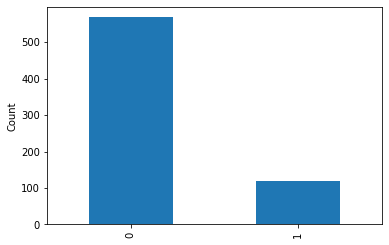

In [6]:
# Train set
X = dataset.drop('label', axis=1)
y = dataset['label']

# visualiser la distribution des classes
y.value_counts().plot(kind='bar')
plt.xticks()
plt.ylabel('Count')
y.value_counts()

In [7]:
# Normaliser la dataset
#transformer = preprocessing.normalize(dataset, norm='l1')

# Standardiser la dataset
X = StandardScaler().fit_transform(X)

(686, 134)
(686, 134)


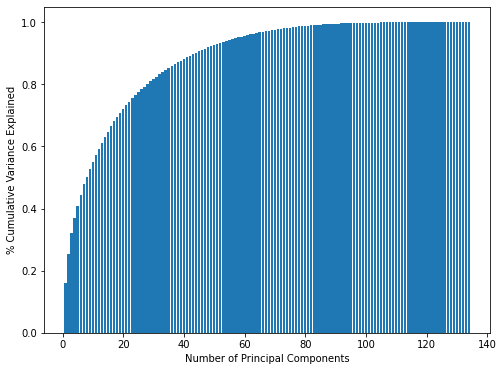

In [8]:
MAX_FEATURES = 134
# Feature dimension reduction avec PCA
pca = PCA(n_components=MAX_FEATURES)
print(X.shape)
pca.fit(X)
X_pca = pca.transform(X)

print(X_pca.shape)


# Calculate cumulative explained variance across all PCs

cum_exp_var = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cum_exp_var.append(var_exp)

# Plot cumulative explained variance for all PCs

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,MAX_FEATURES+1), cum_exp_var)
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');

In [9]:
SELECTED_MAX_COMPONENT = 10

# check model performance before hyperparameters tuning (default)
X = X_pca[:,0:SELECTED_MAX_COMPONENT]
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)
# Perform feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
# check model performance before hyperparameters tuning (default)
X = X_pca[:,0:SELECTED_MAX_COMPONENT]
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)
# Perform feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [11]:
# FIT BEST MODEL
X = X_pca[:,0:SELECTED_MAX_COMPONENT]

print(X.shape)

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)

# Perform feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# use SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_test = svm_model.predict(X_test)

# check performance with classification report
print(classification_report(y_test, y_pred_test))
# check performance with ROC score
print("\nROC Score : ", roc_auc_score(y_test, y_pred_test))

(686, 10)
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       135
           1       0.82      0.84      0.83        37

    accuracy                           0.92       172
   macro avg       0.89      0.89      0.89       172
weighted avg       0.93      0.92      0.92       172


ROC Score :  0.892992992992993


In [12]:
coded_ids_labels_test = pd.read_csv("Social_spammers_dataset/users/coded_ids_labels_test.csv")
test_dataset = pd.merge(coded_ids, coded_ids_labels_test)
test_dataset = pd.merge(test_dataset, features)
test_dataset.info()
test_dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 0 to 80
Columns: 147 entries, coded_id to utc_offset
dtypes: bool(2), float64(94), int64(43), object(8)
memory usage: 92.5+ KB


,coded_id,user_id,label,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,...,temporal_bin_7,time_since_newest_tweet_days,time_since_newest_tweet_months,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average,utc_offset
0,5,1145742354,NaN,1.350,11.016,6.480,210.844,1.000,1833,0 days 17:49:13.654040000,...,0.194,1,0.033333,Baghdad,3.202,18,6,0,1.000,10800.0
1,26,1555076659,NaN,10.256,1.000,1.000,400.000,1.000,1688,0 days 02:22:54.759398000,...,0.500,1,0.033333,NaN,4.012,0,0,20,1.000,NaN
2,37,1732102699,NaN,5.000,50.798,9.538,307.410,2.942,1619,0 days 04:49:24.883249000,...,0.162,653,21.766667,Riyadh,1.636,15,13,3,1.211,10800.0
3,40,1873016161,NaN,13.793,15.045,14.117,400.000,1.000,1608,0 days 01:47:42.383459000,...,0.152,0,0.000000,Kuwait,31.374,20,6,5,1.000,10800.0
4,52,2286370481,NaN,3.102,4.578,16.791,271.495,25.783,1486,0 days 07:47:00.945255000,...,0.126,990,33.000000,NaN,4.122,20,5,3,2.556,NaN


In [13]:
column_to_drop = not_numeric_column + to_drop + ids + ['label']
print(column_to_drop)

['avg_intertweet_times', 'date_newest_tweet', 'date_oldest_tweet', 'lang', 'max_intertweet_times', 'min_intertweet_times', 'std_intertweet_times', 'spam_in_screen_name', 'time_zone', 'utc_offset', 'coded_id', 'user_id', 'label']


In [14]:
X_pred = test_dataset.drop(column_to_drop, 1)

In [15]:
pca = PCA(n_components=81)
pca.fit(X_pred)
X_pred_pca = pca.transform(X_pred)
X_pred = X_pred_pca[:,0:SELECTED_MAX_COMPONENT]
print(X_pred.shape)
# Perform feature scaling
scaler = StandardScaler()
scaler.fit_transform(X_train)
X_pred = scaler.transform(X_pred) 
y_pred = svm_model.predict(X_pred)

(81, 10)


In [16]:
print(y_pred)
test_dataset['label'] = y_pred
test_dataset.head()

[0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


,coded_id,user_id,label,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,...,temporal_bin_7,time_since_newest_tweet_days,time_since_newest_tweet_months,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average,utc_offset
0,5,1145742354,0,1.350,11.016,6.480,210.844,1.000,1833,0 days 17:49:13.654040000,...,0.194,1,0.033333,Baghdad,3.202,18,6,0,1.000,10800.0
1,26,1555076659,0,10.256,1.000,1.000,400.000,1.000,1688,0 days 02:22:54.759398000,...,0.500,1,0.033333,NaN,4.012,0,0,20,1.000,NaN
2,37,1732102699,0,5.000,50.798,9.538,307.410,2.942,1619,0 days 04:49:24.883249000,...,0.162,653,21.766667,Riyadh,1.636,15,13,3,1.211,10800.0
3,40,1873016161,0,13.793,15.045,14.117,400.000,1.000,1608,0 days 01:47:42.383459000,...,0.152,0,0.000000,Kuwait,31.374,20,6,5,1.000,10800.0
4,52,2286370481,1,3.102,4.578,16.791,271.495,25.783,1486,0 days 07:47:00.945255000,...,0.126,990,33.000000,NaN,4.122,20,5,3,2.556,NaN


In [17]:
selected_columns = test_dataset[["coded_id","label"]]
result_dataset = selected_columns.copy()
result_dataset.head(30)
result_dataset.to_csv("Social_spammers_dataset/users/coded_ids_labels_test_result_svm.csv", index=False)

0    73
1     8
Name: label, dtype: int64


Text(0, 0.5, 'Count')

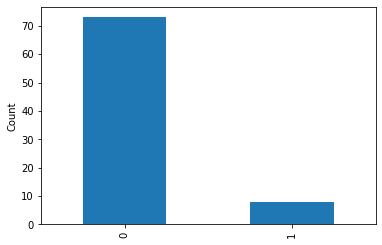

In [18]:
result_dataset['label'].value_counts().plot(kind='bar')
print(result_dataset['label'].value_counts())
plt.xticks()
plt.ylabel('Count')